In [1]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# bring in data
data = pd.read_csv('../data/regional_univariate_data.csv')
enc = pd.read_csv('../data/regional_datasets/univariate/enc_data_univ.csv').drop(columns = 'Unnamed: 0')
esc = pd.read_csv('../data/regional_datasets/univariate/esc_data_univ.csv').drop(columns = 'Unnamed: 0')
midatl = pd.read_csv('../data/regional_datasets/univariate/mid_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
mount = pd.read_csv('../data/regional_datasets/univariate/mountain_data_univ.csv').drop(columns = 'Unnamed: 0')
ne = pd.read_csv('../data/regional_datasets/univariate/new_england_data_univ.csv').drop(columns = 'Unnamed: 0')
pac = pd.read_csv('../data/regional_datasets/univariate/pacific_data_univ.csv').drop(columns = 'Unnamed: 0')
satl = pd.read_csv('../data/regional_datasets/univariate/south_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
wnc = pd.read_csv('../data/regional_datasets/univariate/wnc_data_univ.csv').drop(columns = 'Unnamed: 0')
wsc = pd.read_csv('../data/regional_datasets/univariate/wsc_data_univ.csv').drop(columns = 'Unnamed: 0')

# prepare data
def prepare_and_split_data(data, test_size = 0.15):
    data = data.sort_values('date')
    testsize = int(len(data) * (1-test_size))
    train, test = data[0:testsize], data[testsize:]
    return train, test

enc_train, enc_test = prepare_and_split_data(enc)
esc_train, esc_test = prepare_and_split_data(esc)
midatl_train, midatl_test = prepare_and_split_data(midatl)
mount_train, mount_test = prepare_and_split_data(mount)
ne_train, ne_test = prepare_and_split_data(ne)
pac_train, pac_test = prepare_and_split_data(pac)
satl_train, satl_test = prepare_and_split_data(satl)
wnc_train, wnc_test = prepare_and_split_data(wnc)
wsc_train, wsc_test = prepare_and_split_data(wsc)
print("Length enc train: ", len(enc_train))
print("Length enc test: ", len(enc_test))

Length enc train:  822
Length enc test:  146


In [11]:
def search_auto_arima(train, test, m = [1, 7, 12], max_q = 7, max_p = 7, max_Q = 7, max_P = 7): 
    models = {}
    for val in m:
        auto_model = auto_arima(enc_train['new_confirmed'], seasonal=True, m=val, suppress_warnings=True, stepwise=True, max_q=max_q, max_p=max_p, max_Q = max_Q, max_P = max_P)
        n_periods = len(test['new_confirmed'])
        forecast = auto_model.predict(n_periods=n_periods)
        actuals = test['new_confirmed']

        mae = mean_absolute_error(actuals, forecast)
        rmse = np.sqrt(mean_squared_error(actuals, forecast))
        mase = mean_absolute_scaled_error(actuals, forecast, y_train=train['new_confirmed'])
        print(mase)

        models[val] = (auto_model, mase, mae, rmse, forecast)
    best_model = min(models, key = lambda k: models[k][1])
    model, mase, mae, rmse, forecast = models[best_model]
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"MASE: {mase}")
    print(model.summary())

    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test['new_confirmed'], label='New Cases', color = 'blue')
    plt.plot(test['new_confirmed'].index, forecast, label='Predicted New Cases', color = 'red')
    plt.title('Actual and Predicted Daily New Cases')
    plt.xlabel('Date')
    plt.ylabel('New Cases')
    plt.legend()
    plt.show()

# ENC

1.1220320119437992
1.2814734946195547
4.084107514648901
1.0894797866163126
MAE: 8640.296604339856
RMSE: 10628.236240163375
MASE: 1.0894797866163126
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  822
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 14)   Log Likelihood               -8801.224
Date:                             Sat, 02 Mar 2024   AIC                          17614.447
Time:                                     13:16:24   BIC                          17642.710
Sample:                                          0   HQIC                         17625.291
                                             - 822                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

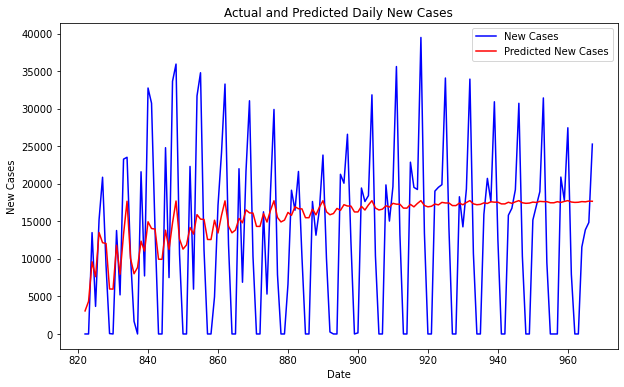

In [22]:
search_auto_arima(enc_train, enc_test, m = [1, 2,  7, 14], max_q = 21, max_p = 14, max_P = 14, max_Q = 21)

In [8]:
auto_model = auto_arima(enc_train['new_confirmed'], seasonal=True, m=1, suppress_warnings=True, stepwise=True, max_q=7, max_p=7, max_Q = 7, max_P = 7)

n_periods = len(enc_test['new_confirmed'])
forecast = auto_model.predict(n_periods=n_periods)

actuals = enc_test['new_confirmed']

mae = mean_absolute_error(actuals, forecast)

rmse = np.sqrt(mean_squared_error(actuals, forecast))

y_train = enc_train['new_confirmed']
mase = mean_absolute_scaled_error(actuals, forecast, y_train=y_train)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MASE: {mase}")

print(auto_model.summary())

MAE: 9194.052195112905
RMSE: 11269.654462297894
MASE: 1.1593044177024705
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  822
Model:               SARIMAX(7, 1, 5)   Log Likelihood               -8676.015
Date:                Sat, 02 Mar 2024   AIC                          17378.030
Time:                        12:19:41   BIC                          17439.266
Sample:                             0   HQIC                         17401.525
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0219      0.025     -0.889      0.374      -0.070       0.026
ar.L2         -0.0035      0.026     -0.136      0.892    

/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


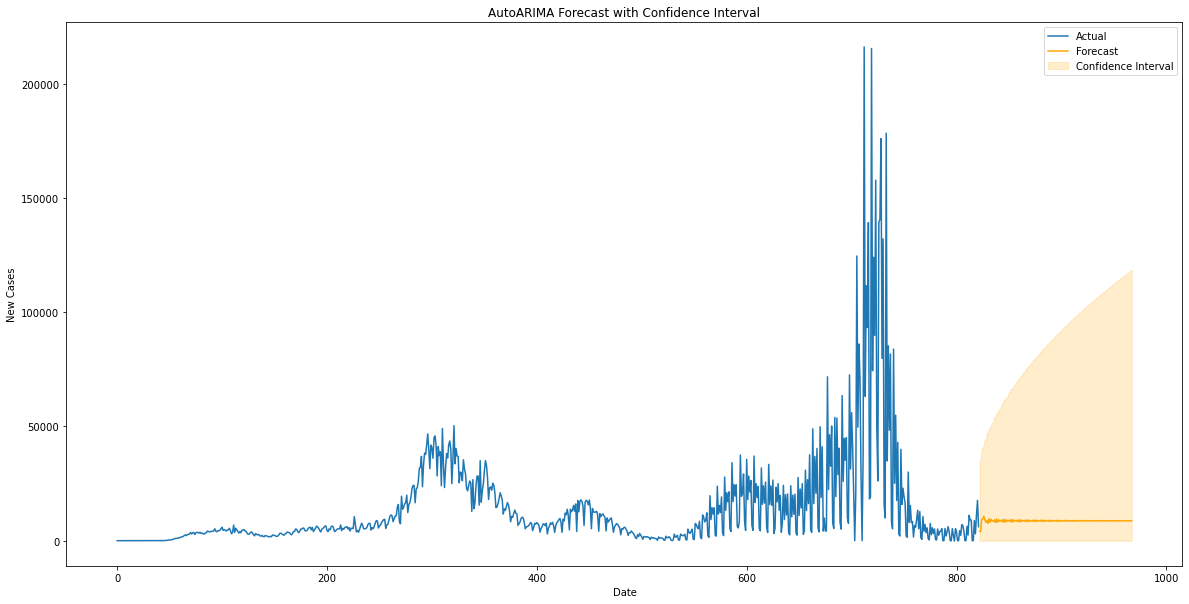

In [11]:
forecast, conf_int = auto_model.predict(n_periods=len(enc_test), return_conf_int=True)
for i in conf_int:
    if i[0] < 0:
        i[0] = 0

#test_dates =  #pd.date_range(df.index[-1], periods=n_periods + 1, freq=df.index.freq)[-n_periods:]
plt.figure(figsize= (20,10))
plt.plot(np.array(enc_train.index), np.array(enc_train['new_confirmed']), label='Actual')

plt.plot(np.array(enc_test.index), np.array(forecast), label='Forecast', color='orange')

plt.fill_between(enc_test.index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()
plt.show()

In [20]:
def log_transform(x):
    return np.log(x) if x > 0 else 0

log_auto_model = auto_arima(enc_train['new_confirmed'].apply(lambda x: log_transform(x)), seasonal=True, m=1, suppress_warnings=True, stepwise=True, max_q=4, max_p=4, max_Q = 4, max_P = 4)
print(log_auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  822
Model:               SARIMAX(4, 1, 4)   Log Likelihood               -1103.283
Date:                Fri, 23 Feb 2024   AIC                           2224.567
Time:                        11:10:27   BIC                           2266.962
Sample:                             0   HQIC                          2240.833
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8526      0.017     51.008      0.000       0.820       0.885
ar.L2         -1.3263      0.022    -60.445      0.000      -1.369      -1.283
ar.L3          0.6824      0.019     35.528      0.0

/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


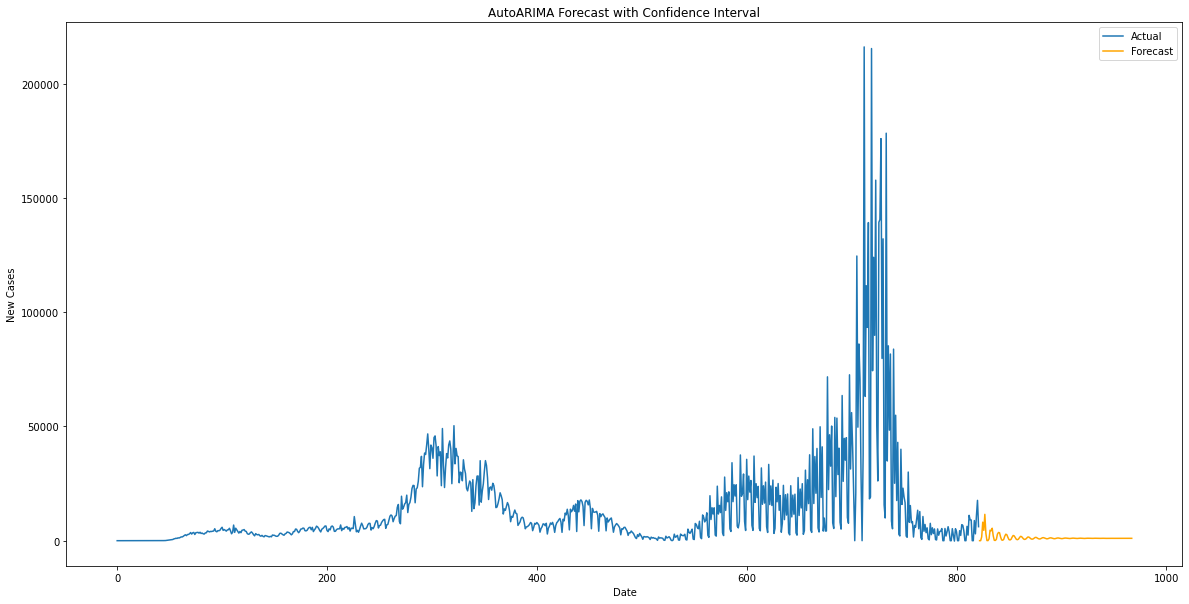

In [28]:
forecast, conf_int = log_auto_model.predict(n_periods=len(enc_test), return_conf_int=True)
forecast = np.exp(forecast)
conf_int = np.exp(conf_int)
# for i in conf_int:
#     if i[0] < 0:
#         i[0] = 0

#test_dates =  #pd.date_range(df.index[-1], periods=n_periods + 1, freq=df.index.freq)[-n_periods:]
plt.figure(figsize= (20,10))
plt.plot(np.array(enc_train.index), np.array(enc_train['new_confirmed']), label='Actual')

plt.plot(np.array(enc_test.index), np.array(forecast), label='Forecast', color='orange')

# plt.fill_between(enc_test.index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()
plt.show()

# ESC

1.7680635893630041
8.078958875345618
3.1141236663565994
MAE: 5858.776969867258
RMSE: 6950.192387470907
MASE: 1.7680635893630041
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  822
Model:               SARIMAX(7, 1, 5)   Log Likelihood               -8676.015
Date:                Sat, 02 Mar 2024   AIC                          17378.030
Time:                        13:00:52   BIC                          17439.266
Sample:                             0   HQIC                         17401.525
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0219      0.025     -0.889      0.374      -0.070       0.026
ar.

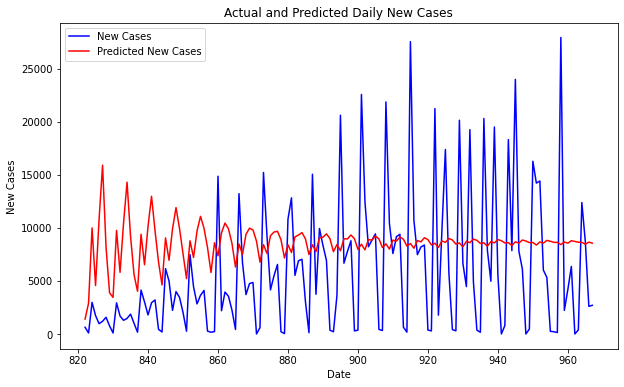

In [18]:
search_auto_arima(esc_train, esc_test, m = [1, 7, 14], max_q = 21, max_Q = 21)

# MidAtl

2.763340801208206
14.834780959398415
3.034251449156996
MAE: 5858.952297367049
RMSE: 7665.484802341048
MASE: 2.763340801208206
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  822
Model:               SARIMAX(7, 1, 5)   Log Likelihood               -8676.015
Date:                Sat, 02 Mar 2024   AIC                          17378.030
Time:                        13:04:36   BIC                          17439.266
Sample:                             0   HQIC                         17401.525
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0219      0.025     -0.889      0.374      -0.070       0.026
ar.L2

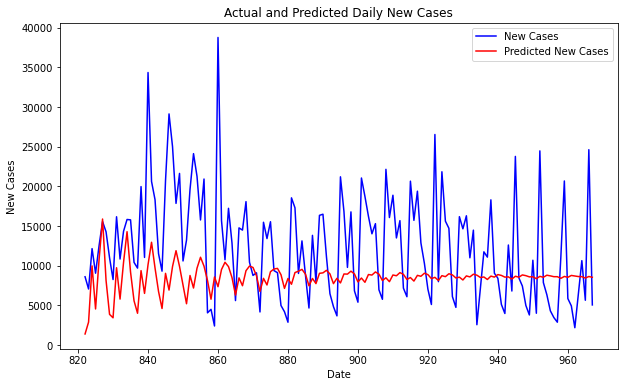

In [19]:
search_auto_arima(midatl_train, midatl_test, m = [1, 7, 14], max_q = 21, max_Q = 21)

# Mountain

1.789259247088245
8.427136731873798
3.29180724573657
MAE: 5658.189118817407
RMSE: 7300.279978068899
MASE: 1.789259247088245
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  822
Model:               SARIMAX(7, 1, 5)   Log Likelihood               -8676.015
Date:                Sat, 02 Mar 2024   AIC                          17378.030
Time:                        13:18:56   BIC                          17439.266
Sample:                             0   HQIC                         17401.525
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0219      0.025     -0.889      0.374      -0.070       0.026
ar.L2  

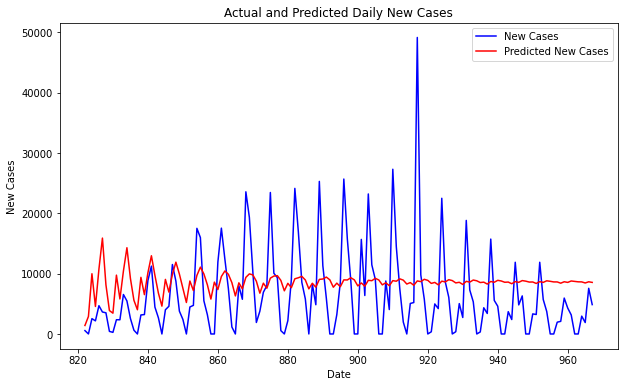

In [23]:
search_auto_arima(mount_train, mount_test, m = [1, 7, 14], max_q = 21, max_Q = 21)

# Old Work Below

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  823
Model:             SARIMAX(3, 1, 2)x(2, 0, 2, 4)   Log Likelihood               -8932.484
Date:                           Tue, 20 Feb 2024   AIC                          17884.967
Time:                                   12:49:20   BIC                          17932.085
Sample:                               01-22-2020   HQIC                         17903.044
                                    - 04-23-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1669      0.013    -87.930      0.000      -1.193      -1.141
ar.L2         -1.2947      0.006   -207.996

/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


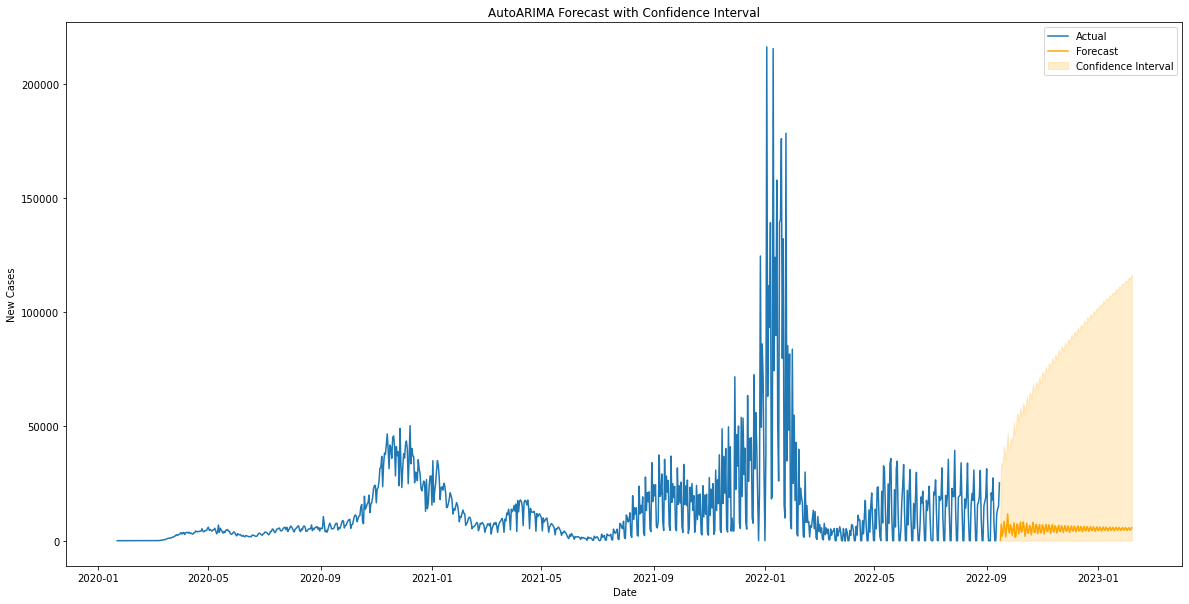

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  823
Model:             SARIMAX(3, 1, 3)x(2, 0, [1, 2], 4)   Log Likelihood               -8272.555
Date:                                Tue, 20 Feb 2024   AIC                          16567.109
Time:                                        13:00:01   BIC                          16618.938
Sample:                                    01-22-2020   HQIC                         16586.994
                                         - 04-23-2022                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0681      0.038    -28.139      0.000      -1.142      -0.994
ar.

/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


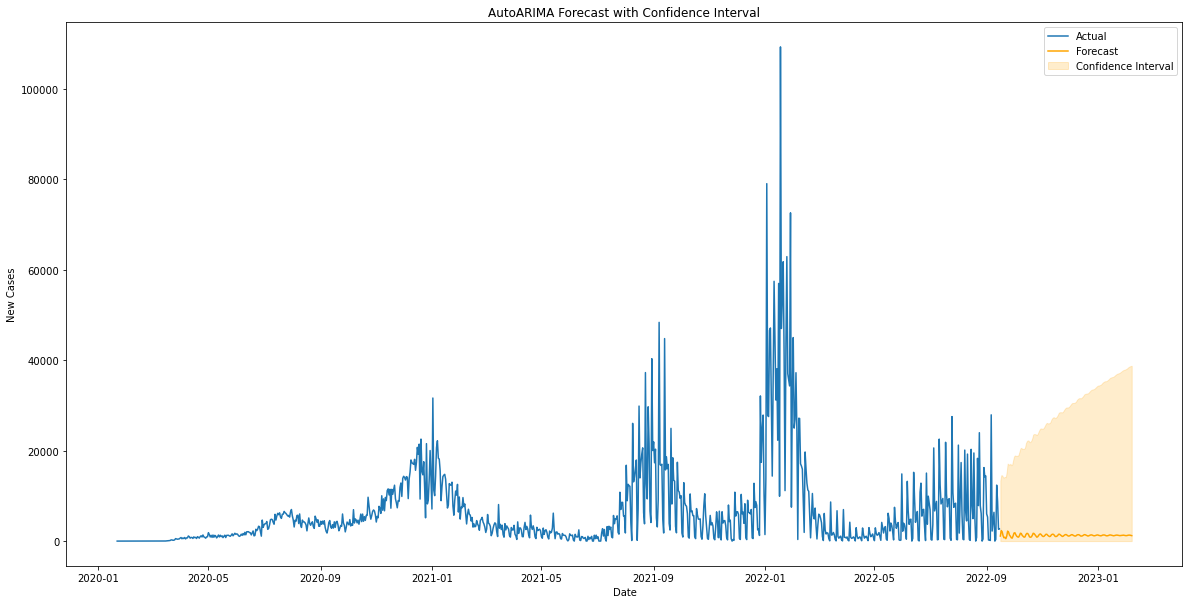

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  823
Model:             SARIMAX(3, 1, 2)x(1, 0, 2, 4)   Log Likelihood               -8122.784
Date:                           Tue, 20 Feb 2024   AIC                          16263.568
Time:                                   13:00:45   BIC                          16305.974
Sample:                               01-22-2020   HQIC                         16279.838
                                    - 04-23-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7423      0.021     35.965      0.000       0.702       0.783
ar.L2         -0.3683      0.016    -22.696

/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


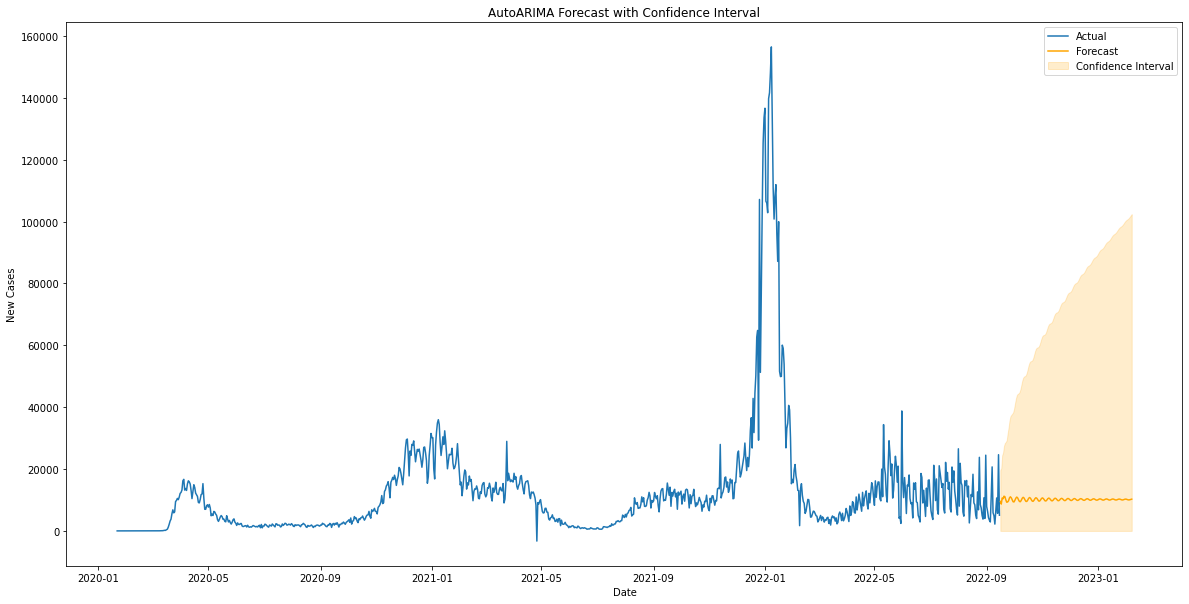

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  823
Model:             SARIMAX(3, 1, 3)x(0, 0, [1, 2], 4)   Log Likelihood               -8350.719
Date:                                Tue, 20 Feb 2024   AIC                          16719.438
Time:                                        13:01:34   BIC                          16761.843
Sample:                                    01-22-2020   HQIC                         16735.707
                                         - 04-23-2022                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1584      0.022    -52.755      0.000      -1.201      -1.115
ar.

/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


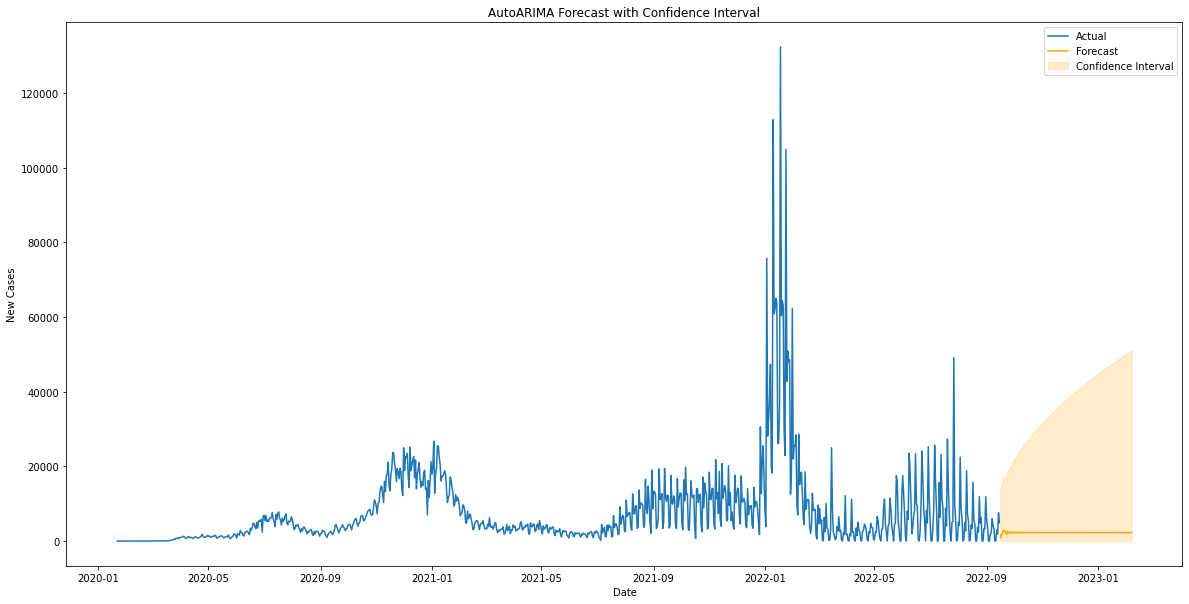

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  823
Model:             SARIMAX(3, 1, 2)x(2, 0, 2, 4)   Log Likelihood               -8221.171
Date:                           Tue, 20 Feb 2024   AIC                          16462.342
Time:                                   13:02:28   BIC                          16509.459
Sample:                               01-22-2020   HQIC                         16480.419
                                    - 04-23-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1926      0.017    -71.898      0.000      -1.225      -1.160
ar.L2         -1.2404      0.010   -121.149

/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


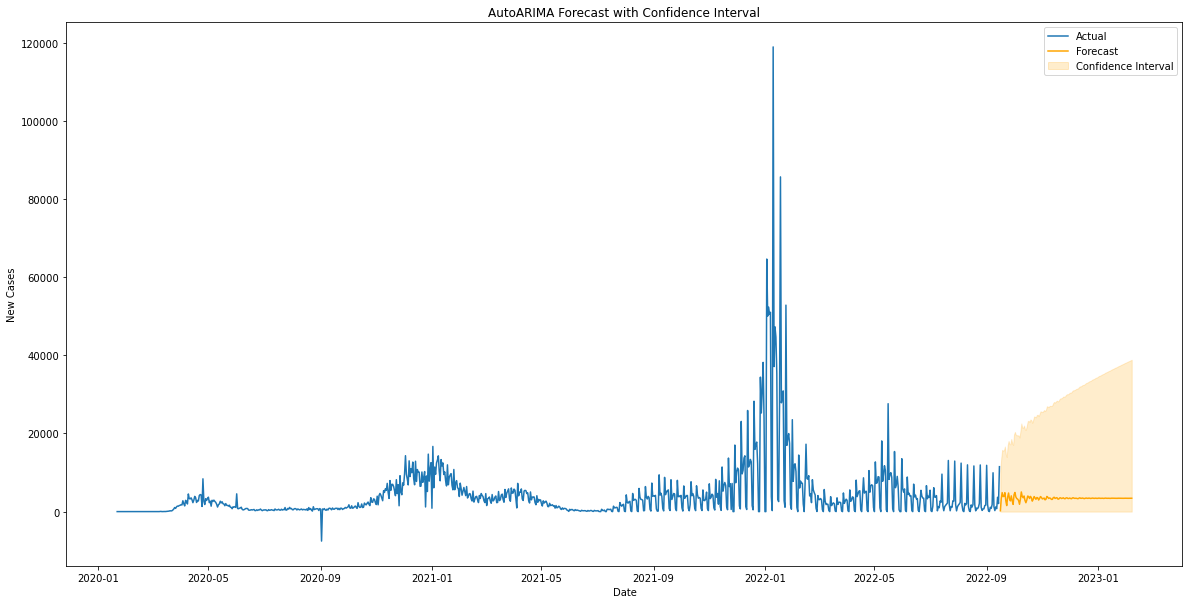

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  823
Model:             SARIMAX(3, 1, 3)x(2, 0, [1, 2], 4)   Log Likelihood               -9002.084
Date:                                Tue, 20 Feb 2024   AIC                          18026.168
Time:                                        13:03:29   BIC                          18077.998
Sample:                                    01-22-2020   HQIC                         18046.053
                                         - 04-23-2022                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0366      0.050     -0.736      0.461      -0.134       0.061
ar.

/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


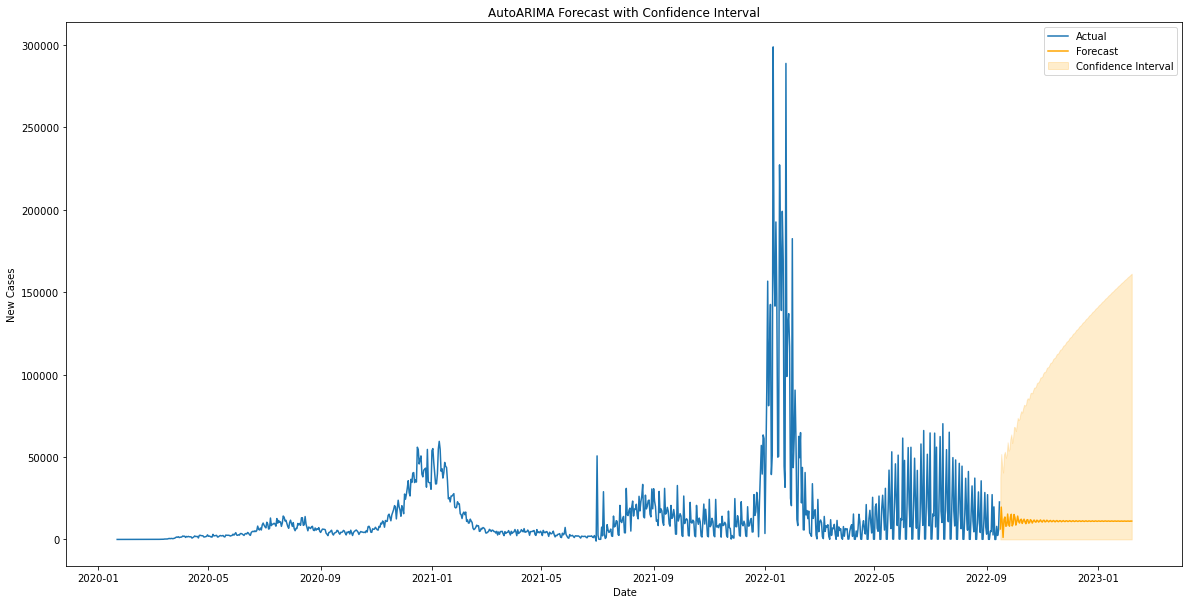

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  823
Model:             SARIMAX(2, 1, 3)x(2, 0, [1, 2], 4)   Log Likelihood               -9284.604
Date:                                Tue, 20 Feb 2024   AIC                          18589.207
Time:                                        13:04:09   BIC                          18636.324
Sample:                                    01-22-2020   HQIC                         18607.284
                                         - 04-23-2022                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1176      0.032     34.663      0.000       1.054       1.181
ar.

/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


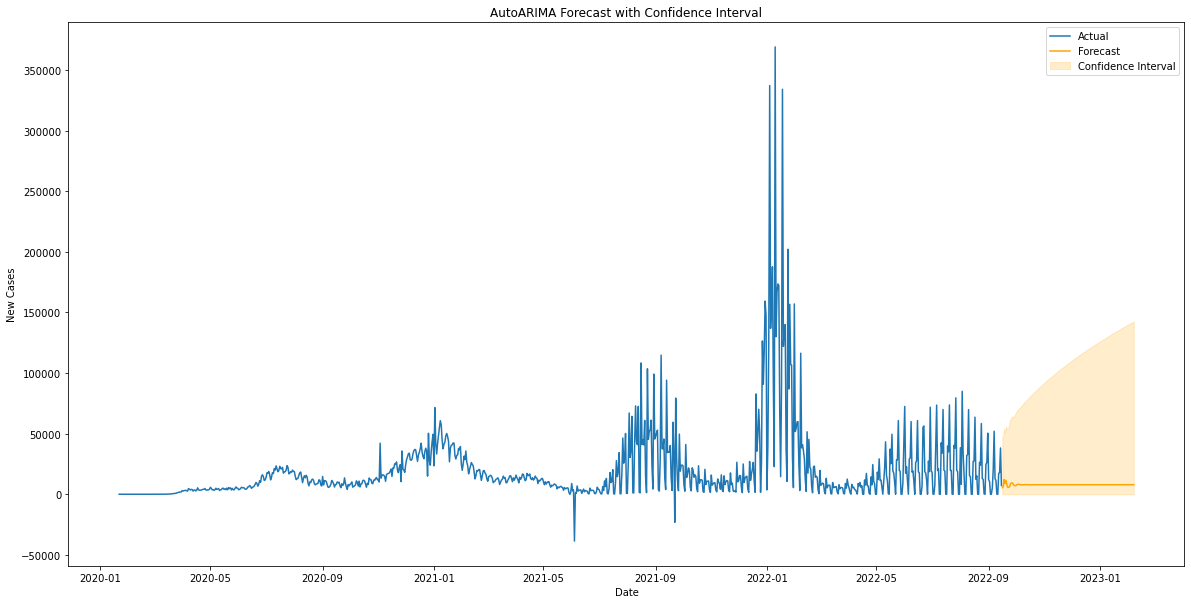

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  823
Model:             SARIMAX(3, 1, 2)x(2, 0, [], 4)   Log Likelihood               -8223.326
Date:                            Tue, 20 Feb 2024   AIC                          16462.652
Time:                                    13:04:38   BIC                          16500.346
Sample:                                01-22-2020   HQIC                         16477.114
                                     - 04-23-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8545      0.019     44.871      0.000       0.817       0.892
ar.L2         -0.4400      0.017   

/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


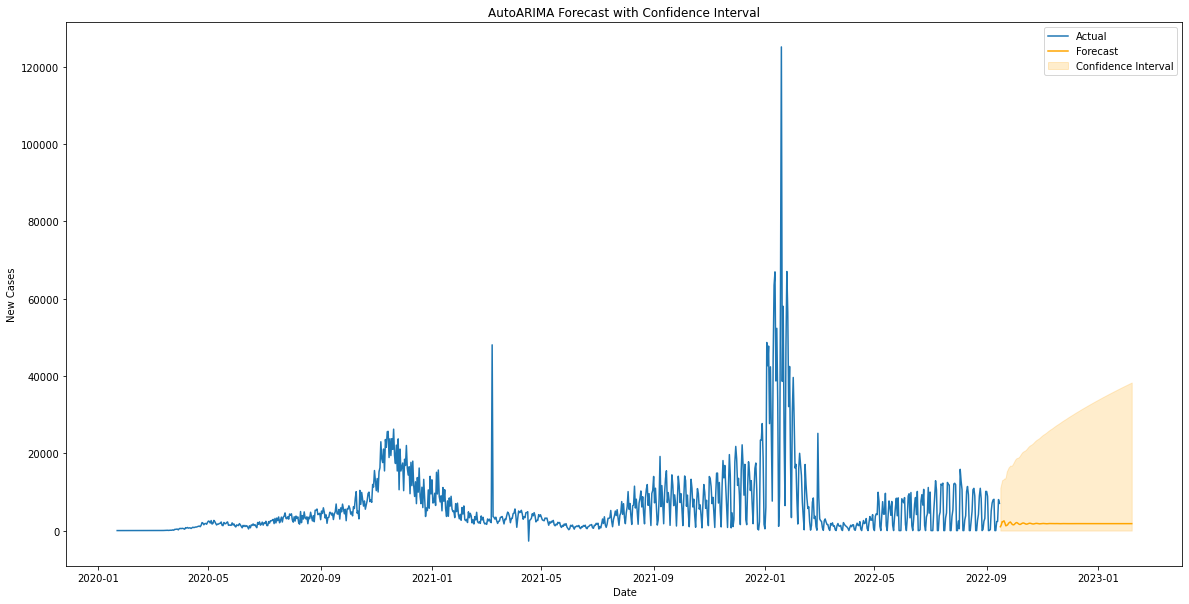

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  823
Model:             SARIMAX(3, 1, 3)x(0, 0, [1, 2], 4)   Log Likelihood               -8690.319
Date:                                Tue, 20 Feb 2024   AIC                          17398.637
Time:                                        13:05:23   BIC                          17441.043
Sample:                                    01-22-2020   HQIC                         17414.907
                                         - 04-23-2022                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9838      0.053    -18.667      0.000      -1.087      -0.880
ar.

/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


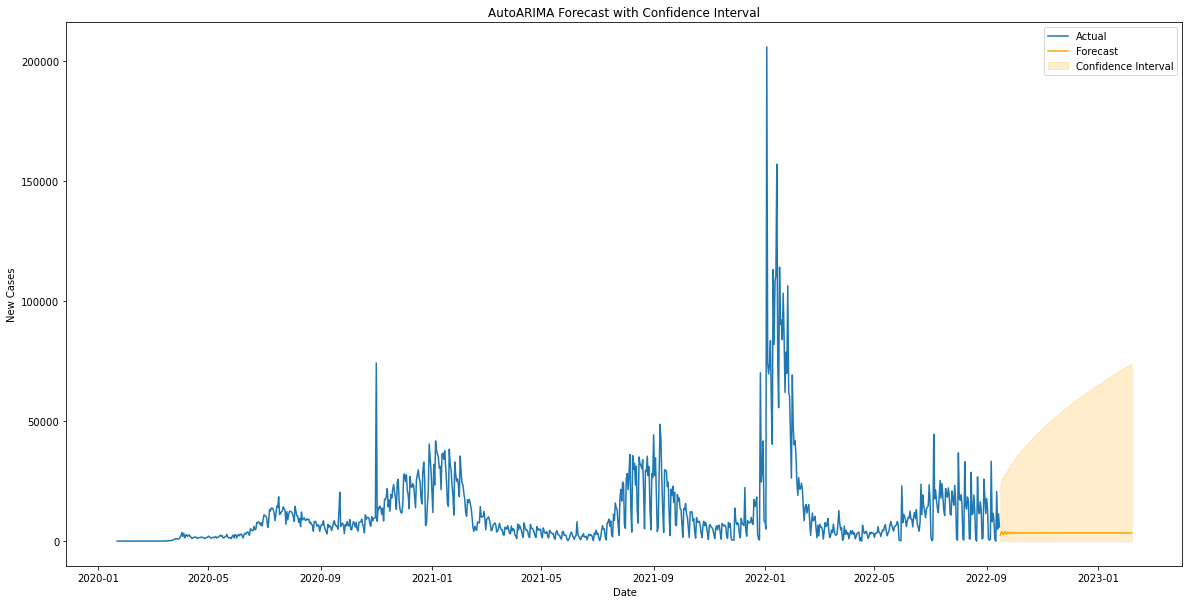

In [4]:
train_test_split = 0.15
for df in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
    df = df[['date', 'new_confirmed']]
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    df.index=pd.to_datetime(df.index)   
    size = round(df.shape[0]*train_test_split)
    train = df.iloc[:-size]
    test = df.iloc[-size:]
    auto_model = auto_arima(train['new_confirmed'], seasonal=True, m=4, suppress_warnings=True, stepwise=True, max_q=14, max_p=21)
    print(auto_model.summary())

    n_periods= len(test)
    forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)
    for i in conf_int:
        if i[0] < 0:
            i[0] = 0

    forecast_index = pd.date_range(df.index[-1], periods=n_periods + 1, freq=df.index.freq)[-n_periods:]
    plt.figure(figsize= (20,10))
    plt.plot(np.array(df.index), np.array(df['new_confirmed']), label='Actual')

    plt.plot(np.array(forecast_index), np.array(forecast), label='Forecast', color='orange')

    plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

    plt.title('AutoARIMA Forecast with Confidence Interval')
    plt.xlabel('Date')
    plt.ylabel('New Cases')
    plt.legend()
    plt.show()

# Below is Old Code, put new stuff above

In [ ]:
df = pd.read_csv('../data/regional_datasets/univariate/enc_data_univ.csv')
df = df[['date', 'new_confirmed']]
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
df.index=pd.to_datetime(df.index)
df.head()

,new_confirmed
date,
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,1.0
2020-01-25,0.0
2020-01-26,0.0


In [ ]:
size = round(df.shape[0]*0.1)
train = df.iloc[:-size]
test = df.iloc[-size:] 
train.head()

,new_confirmed
date,
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,1.0
2020-01-25,0.0
2020-01-26,0.0


In [ ]:
auto_model = auto_arima(train['new_confirmed'], seasonal=True, m=52, suppress_warnings=True, stepwise=True, max_q=14, max_p=21)
print(auto_model.summary())

                                       SARIMAX Results                                       
Dep. Variable:                                     y   No. Observations:                  871
Model:             SARIMAX(14, 1, 0)x(0, 0, [1], 52)   Log Likelihood               -9163.572
Date:                               Mon, 19 Feb 2024   AIC                          18361.144
Time:                                       16:39:23   BIC                          18442.209
Sample:                                   01-22-2020   HQIC                         18392.162
                                        - 06-10-2022                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     26.9366    477.082      0.056      0.955    -908.126     961.999
ar.L1      

In [ ]:
n_periods= len(test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

print("Forecast:", forecast)

Forecast: 2022-06-11     3080.161778
2022-06-12     1224.723857
2022-06-13    16742.071460
2022-06-14     9563.357898
2022-06-15    19083.330070
                  ...     
2022-09-11    11353.137960
2022-09-12    13463.485828
2022-09-13    12117.759591
2022-09-14    14289.118806
2022-09-15    13872.468214
Freq: D, Length: 97, dtype: float64


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [ ]:
print("Confidence Interval:", conf_int)


array([[    0.        , 20310.4693724 ],
       [    0.        , 27987.3014651 ],
       [    0.        , 23118.70229579],
       [    0.        , 28468.79516492],
       [    0.        , 33352.04319674],
       [    0.        , 28664.23088621],
       [    0.        , 22515.94410517],
       [    0.        , 26368.89110829],
       [    0.        , 36557.00536006],
       [    0.        , 31308.24793145],
       [    0.        , 35510.24434391],
       [    0.        , 41930.70778481],
       [    0.        , 37880.29070535],
       [    0.        , 32810.26377478],
       [    0.        , 35484.55562679],
       [    0.        , 42508.88805116],
       [    0.        , 39031.71400403],
       [    0.        , 44044.86105108],
       [    0.        , 48353.59421013],
       [    0.        , 45330.32798468],
       [    0.        , 40813.19350801],
       [    0.        , 41867.05563567],
       [    0.        , 48579.8635224 ],
       [    0.        , 44917.95454424],
       [    0.  

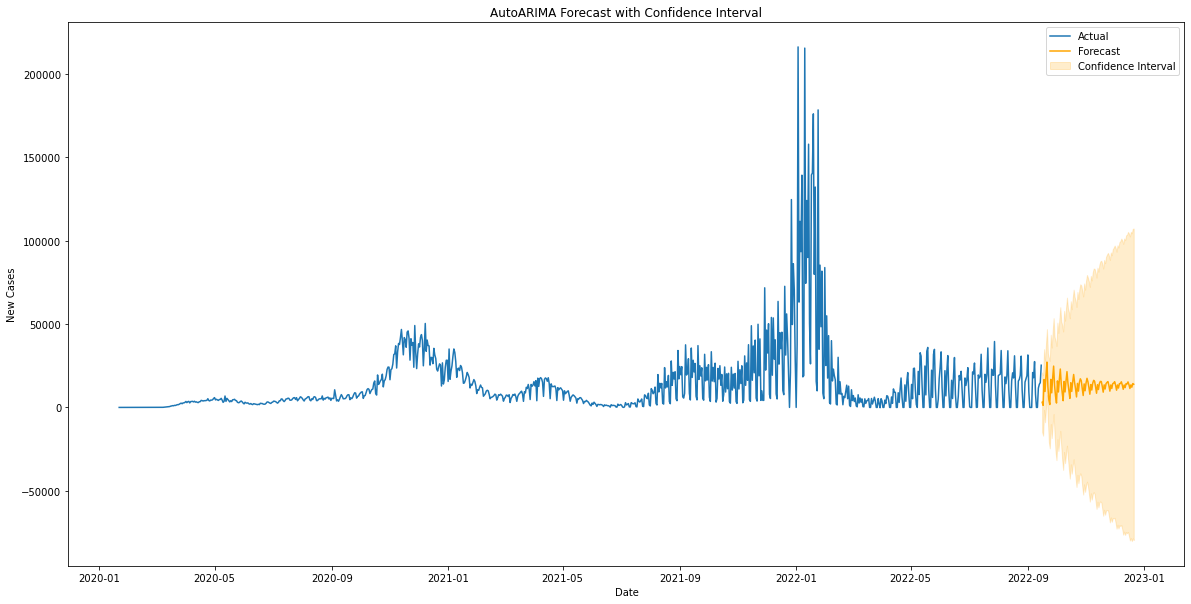

In [ ]:
forecast_index = pd.date_range(df.index[-1], periods=n_periods + 1, freq=df.index.freq)[-n_periods:]
plt.figure(figsize= (20,10))
plt.plot(np.array(df.index), np.array(df['new_confirmed']), label='Actual')

plt.plot(np.array(forecast_index), np.array(forecast), label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()
plt.show()